<a href="https://colab.research.google.com/github/apchavezr/16.-Aprendizaje-Profundo-para-Ciencia-de-Datos/blob/main/cnn_plantvillage_clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de enfermedades de plantas con CNN y PlantVillage

Este cuaderno guía al estudiante en la implementación paso a paso de una red neuronal convolucional (CNN) para clasificar enfermedades de plantas usando el conjunto de datos PlantVillage de Hughes et al., que consta de aproximadamente 87000 imágenes de hojas sanas y enfermas, divididas en 38 categorías por especie y enfermedad. También se incluyen visualizaciones de activaciones y métricas de evaluación como la matriz de confusión y las curvas ROC.
![PlantVillage Dataset Samples](https://i.imgur.com/Zcxdrlc.png)

Este ejercicio permite a los estudiantes adquirir experiencia en tareas prácticas de clasificación de imágenes, visualización de activaciones internas y evaluación del rendimiento de modelos de aprendizaje profundo aplicados a problemas reales del sector agrícola.

**Objetivo del ejercicio**

Entrenar y evaluar una CNN capaz de clasificar imágenes de hojas de plantas sanas y enfermas del conjunto PlantVillage. El estudiante observará cómo la red aprende patrones visuales, analizará las activaciones internas y evaluará métricas como la matriz de confusión y la curva ROC.

## Preparación del entorno

Instalación de librerías necesarias

!pip install -q tensorflow scikit-learn matplotlib seaborn opencv-python

In [ ]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np

import os

## Carga y preprocesamiento de los datos

**a)** Cargar imágenes desde un repositorio de Kaggle o Google Drive

Se recomienda usar un subconjunto del dataset PlantVillage en Kaggle, o subir las carpetas directamente a Colab.

In [ ]:
import kagglehub

# Descargar la última versión
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-plant-diseases-dataset


In [ ]:
base_dir = "../kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir,"train")
test_dir = os.path.join(base_dir,"valid")
print(train_dir)
print(test_dir)

../kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train
../kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid


In [ ]:
image_size = 128
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

batch_size = 32
epochs = 25

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                             shear_range = 0.2,
                                                             zoom_range = 0.2,
                                                             width_shift_range = 0.2,
                                                             height_shift_range = 0.2,
                                                             fill_mode="nearest",
                                                             validation_split=0.5 # Usar solo 50% del total para entrenamiento
                                                             )

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0, validation_split=0.5)

Se usa .flow_from_directory() para generar lotes de datos de imágenes (y sus etiquetas) directamente desde las imágenes en sus respectivas carpetas.

In [ ]:
# Solo 50% del total para entrenamiento
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (image_size, image_size),
                                               batch_size = batch_size,
                                               class_mode = "categorical",
                                               subset="training",  # toma el 50%
                                               shuffle=True
                                               )

# 90% restante para validación
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = batch_size,
                                             class_mode = "categorical",
                                             subset="validation",
                                             shuffle=False
                                             )

Found 35154 images belonging to 38 classes.
Found 8777 images belonging to 38 classes.


In [ ]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

## Construcción de la red neuronal convolucional


In [ ]:
# Construcción de la red neuronal convolucional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Definir el modelo CNN
model = Sequential()

# Capa 1: Convolución + normalización + pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa 2: Convolución + normalización + pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa 3: Convolución + normalización + pooling
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa de aplanamiento y densa
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # regularización para evitar sobreajuste

# Capa de salida
model.add(Dense(38, activation='softmax'))  # 38 clases

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen del modelo
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,526,694 (24.90 MB)

 Trainable params: 6,526,246 (24.90 MB)

 Non-trainable params: 448 (1.75 KB)

 # Entrenamiento del modelo

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Parámetros ajustables
EPOCHS = 2
BATCH_SIZE = 32  # Puede usar 8, 16 o 32 según GPU/CPU disponible
STEPS_PER_EPOCH = train_data.samples // BATCH_SIZE // 4  # usar solo 25% por época
VALIDATION_STEPS = test_data.samples // BATCH_SIZE // 4

# Callbacks para prevenir sobreentrenamiento
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'mejor_modelo.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Entrenamiento
history = model.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_data,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1564 - loss: 3.6014
Epoch 1: val_accuracy improved from -inf to 0.03768, saving model to mejor_modelo.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.1566 - loss: 3.5995 - val_accuracy: 0.0377 - val_loss: 9.5242
Epoch 2/2
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3277 - loss: 2.5169
Epoch 2: val_accuracy improved from 0.03768 to 0.36029, saving model to mejor_modelo.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - accuracy: 0.3277 - loss: 2.5167 - val_accuracy: 0.3603 - val_loss: 2.5656
Restoring model weights from the end of the best epoch: 2.


# Evaluación del rendimiento

a) Matriz de confusión

275/275 ━━━━━━━━━━━━━━━━━━━━ 85s 309ms/step


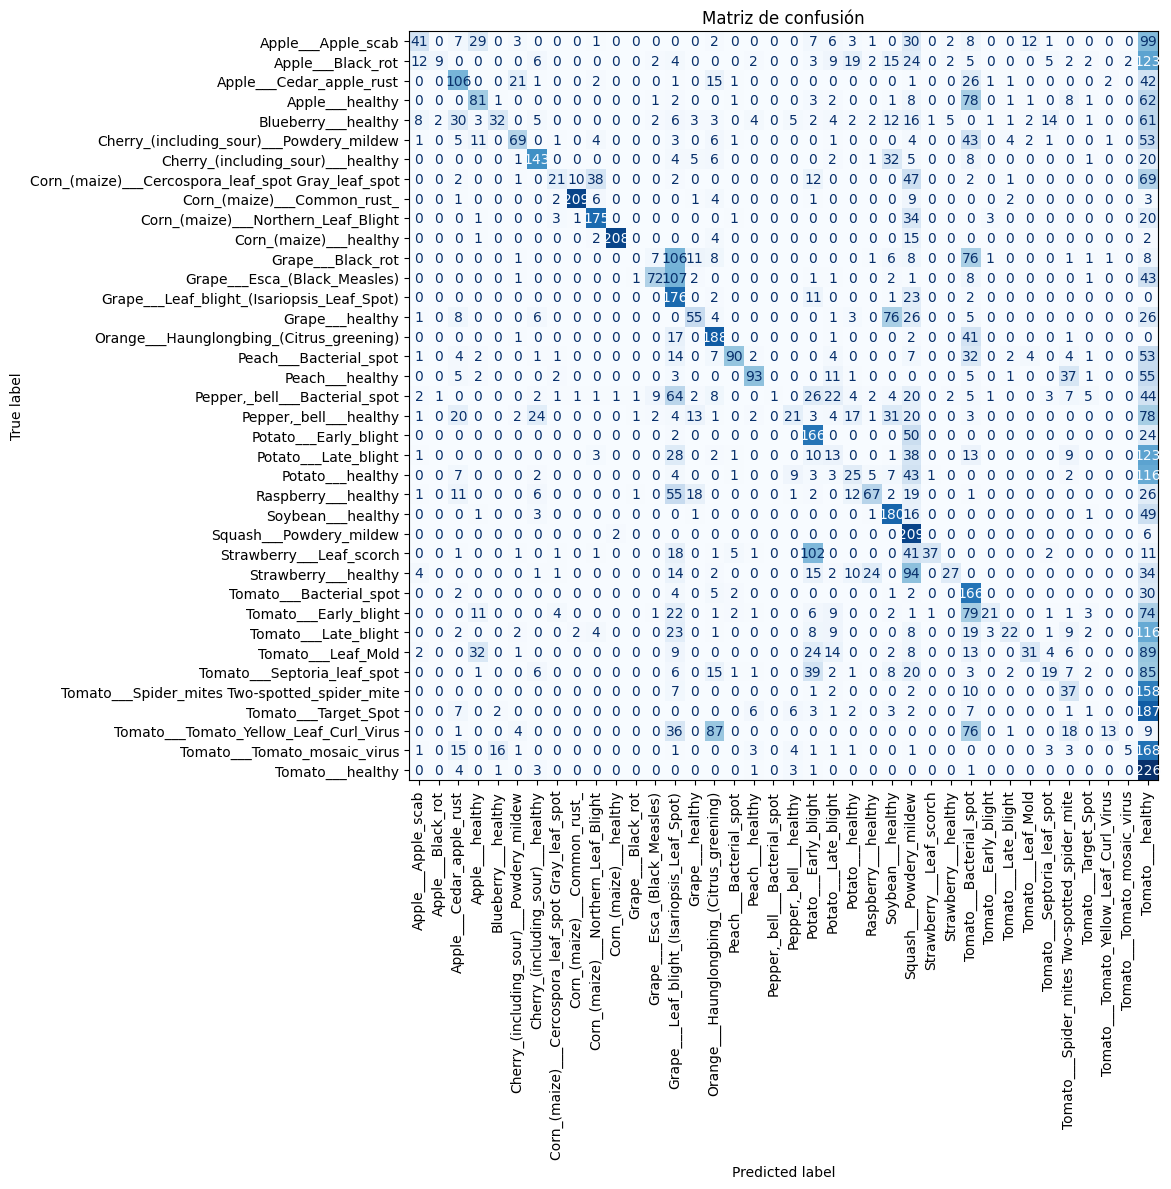

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Asegurar que el generador no se reinicialice aleatoriamente cada vez
test_data.reset()

# Predecir en todos los batches del generador de validación
y_pred = model.predict(test_data, steps=test_data.samples // test_data.batch_size + 1, verbose=1)

# Obtener la clase predicha (índice de la clase con mayor probabilidad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Verdaderas etiquetas del generador
y_true = test_data.classes

# Asegurarse de que el número de predicciones y verdaderos coincidan
y_pred_classes = y_pred_classes[:len(y_true)]

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Etiquetas de clases
class_labels = list(test_data.class_indices.keys())

# Visualización
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', colorbar=False)
plt.title('Matriz de confusión')
plt.tight_layout()
plt.show()

Observaciones destacadas

 * Alta precisión en varias clases:

    Ejemplos como:

    Tomato___Leaf_Mold: 89 predicciones correctas.

    Strawberry___Leaf_scorch: 102 correctas.

    Tomato___Tomato_Yellow_Leaf_Curl_Virus: 87 correctas.

    Apple___Cedar_apple_rust: 106 correctas.

Estos valores altos sobre la diagonal reflejan que el modelo distingue bien esas clases.

*  Errores de clasificación moderados:

  A pesar de la mejora, se observan algunas confusiones frecuentes, por ejemplo:

  Apple___Apple_scab fue confundida 29 veces con Apple___Cedar_apple_rust y 7 con Apple___Black_rot.

  Tomato___Late_blight fue confundida con Tomato___Early_blight en 13 ocasiones.

  Peach___Bacterial_spot fue confundida con Peach___healthy y otras clases vecinas.

* Clases difíciles de distinguir:

 Algunas clases como Corn_(maize)___Northern_Leaf_Blight y Corn_(maize)___Common_rust_ presentan varias confusiones entre sí, lo cual es comprensible debido a que visualmente pueden compartir patrones similares.

b) Curvas ROC para múltiples clases

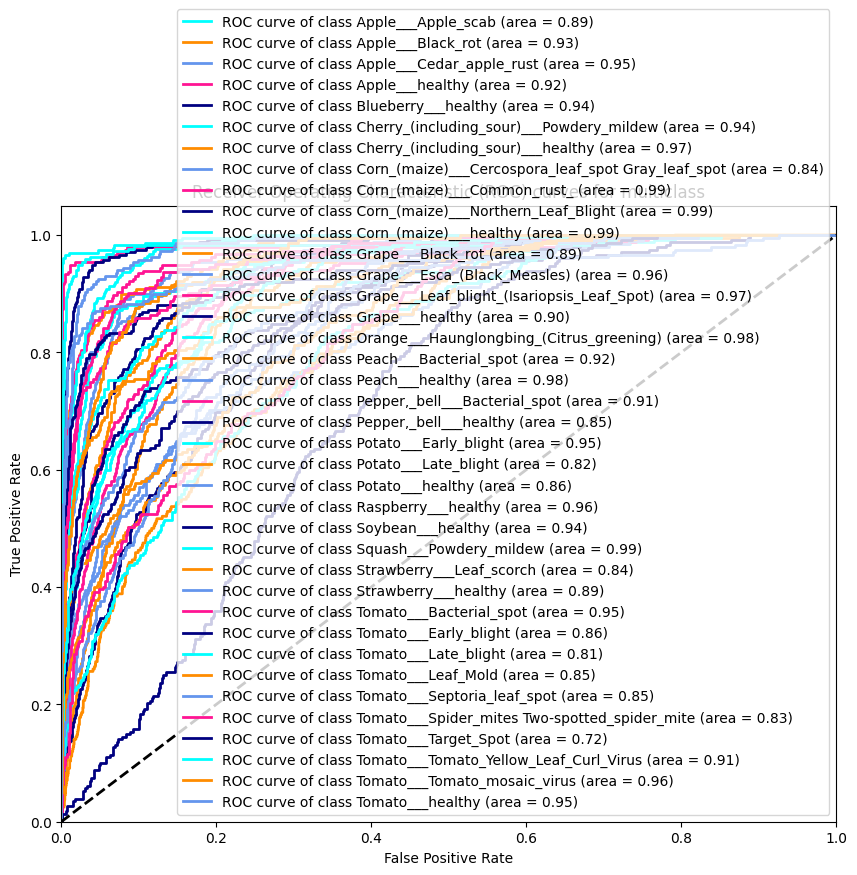

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarizar las etiquetas verdaderas
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_labels)))

# Calcular las curvas ROC y el área bajo la curva (AUC) para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar las curvas ROC para cada clase
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'navy'])
for i, color in zip(range(len(class_labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curves for multiclass')
plt.legend(loc="lower right")
plt.show()

Área bajo la curva:

* Valores de AUC cercanos a 1.0 indican que la clase es bien diferenciada por el modelo.
* Valores entre 0.90 y 0.99 se consideran muy buenos.
* Valores entre 0.80 y 0.89 indican buen desempeño, pero mejorable.
* Valores inferiores a 0.75 pueden sugerir confusión con otras clases.

El modelo logra un rendimiento muy sólido en la mayoría de las clases, con curvas ROC bien diferenciadas. No obstante:

Algunas clases específicas, como Tomato___Target_Spot y Potato___Late_blight, presentan AUC más bajos y se beneficiarían de:

  * Más datos de entrenamiento.
  * Augmentaciones específicas.

  * Mejora en la arquitectura del modelo o fine-tuning adicional.

# Visualización de métricas de entrenamiento

Este código le permite graficar la evolución del entrenamiento para analizar el comportamiento del modelo:

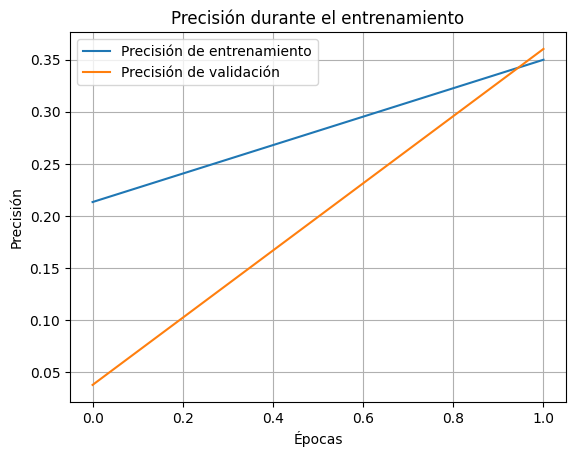

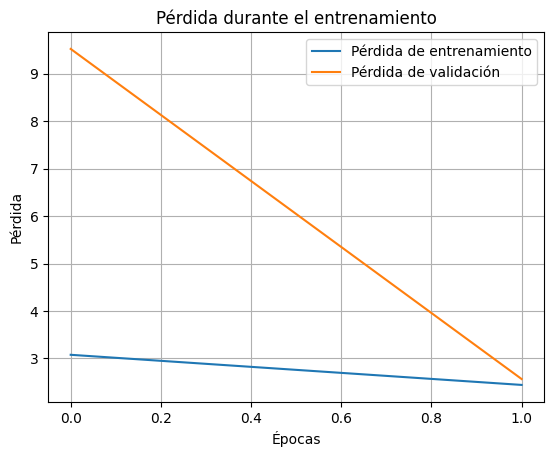

In [ ]:
# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()


**Gráfica 1: Precisión durante el entrenamiento**

* Se observa una tendencia creciente en la precisión tanto del conjunto de entrenamiento como del de validación.

* Aunque el entrenamiento comienza con mayor precisión (≈ 0.22), la validación mejora más rápidamente, alcanzando una precisión incluso ligeramente superior al final de la primera época.

* Esta curva sugiere que el modelo está aprendiendo de manera efectiva y no presenta signos de sobreajuste al final de la primera época.

**Conclusión**: el comportamiento es positivo y sugiere que el modelo puede beneficiarse de más épocas, ya que ambos conjuntos están mejorando sin indicios de saturación ni divergencia.

**Gráfica 2: Pérdida durante el entrenamiento**

* La pérdida disminuye tanto en entrenamiento como en validación, lo cual refuerza la evidencia de aprendizaje efectivo.

* Se destaca que la pérdida de validación comienza alta (≈ 9.5) pero disminuye drásticamente, más incluso que la pérdida de entrenamiento.

* La reducción de la pérdida de validación indica que el modelo generaliza cada vez mejor al conjunto de datos que no ha visto durante el entrenamiento.

**Conclusión:** el modelo muestra una mejora clara y rápida, lo cual es coherente con la mejora en precisión. No hay evidencia de sobreajuste ni de subajuste, aunque una sola época es insuficiente para extraer conclusiones definitivas sobre la generalización.

# Conclusión

Este ejercicio permite:

   *    Entrenar una CNN en imágenes reales de plantas afectadas por enfermedades.

   *  Visualizar cómo las capas convolucionales identifican patrones visuales.

   *  Evaluar objetivamente la capacidad del modelo para generalizar sobre nuevas imágenes.

Este tipo de experiencias contribuye al desarrollo de habilidades prácticas en visión por computador aplicada a contextos agrícolas, útiles en desarrollos de soluciones inteligentes en el sector agropecuario colombiano.

## Referencias

* Hughes, David P., and Marcel Salathe. *An Open Access Repository of Images on Plant Health to Enable the Development of Mobile Disease Diagnostics*.ArXiv:1511.08060 [Cs], Apr. 2016. arXiv.org, http://arxiv.org/abs/1511.08060.

